# Analiza tekmovnj na Codeforces

## Priprava
Najprej moramo naložiti pandas in si pripraviti podatke, ki jih bomo potrebovali za analizo.

In [1]:
import pandas as pd
import os.path

pd.options.display.max_rows = 20

%matplotlib inline

# nalozimo razpredelnice
users_path = os.path.join("obdelani_podatki", "users.csv")
users = pd.read_csv(users_path, index_col='id')

tasks_path = os.path.join("obdelani_podatki", "tasks.csv")
tasks = pd.read_csv(tasks_path, index_col='id')

submissions_path = os.path.join("obdelani_podatki", "submissions.csv")
submissions = pd.read_csv(submissions_path, index_col='id')

In [2]:
users

,name,rank,best_place,country
id,,,,
1,HIR180,Legendary Grandmaster,1,Япония
2,9623,Master,1,Antarctica
3,stasio6,International Master,3,Poland
4,sigma425,International Grandmaster,4,Япония
5,jiangly,Legendary Grandmaster,1,China
...,...,...,...,...
14555,DoIudu123,Newbie,163,Taiwan
14556,logicccc,"Unrated,",166,NaN
14557,EasyMode,Expert,174,Brazil


In [3]:
tasks

,contest,number
id,,
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
...,...,...
1171,189,2
1172,189,3
1173,189,4


In [4]:
submissions

,user,task,proglang,time
id,,,,
1,1,1,c++,1.0
2,1,2,c++,6.0
3,1,3,c++,65.0
4,1,4,c++,26.0
5,1,5,c++,26.0
...,...,...,...,...
234996,14559,451,c++,33.0
234997,14559,452,c++,52.0
234998,14559,453,c++,106.0


Spodobi se najprej na kratko razložiti, kako delujejo tekmovanja na codeforces in kaj pomenijo podatki v posameznih stolpcih tabel.
Na spletni trani codeforces so pokosto tekmobanja, na katerih tekmujejo programerji iz celega sveta. Na vsakem tekmovanju je nekaj nalog (tasks), ki jih morajo tekmovalci (users) rešiti. To naredijo tako, da napišejo ustrezno kodo, ki jo zahteva naloga, in to kodo oddajo. Taki oddajo kode recemo tudi submission.

**Users**  
V tej tabeli se nahajajo podatki tekmovalcev, ki so tekmovali na zadnjih 100 tekmovanjjih.  
Za vsakega imamo podano:
* uporabniško ime
* rank (glede na codeforces rating)
* najboljšo uvrstitev na zadnjih 200 tekmovanjih
* državo (ni zagotovila, da so podatki o državi resnični)

**Tasks**  
Za vsako nalogo imamo shranjeno tekmovanje, na katerem se je pojavila, in zaporedno številko naloge na tem tekmovanju.

**Submissions**  
Za vsako oddajo imamo podane naslednje podatke:
* uporabnik, ki je naredil oddajo
* naloga h kateri spada ta oddaja
* programski jezik
* čas od začetka tekmovanja

Cilj naloge je ovreči ali potrditi naslednje hipoteze:
* Programerji iz Azije so nadpovprečno dobri
* Najboljši tekmovalci prvo nalogo rešijo v manj kot 10 minutah
* Več kot 80 % od vseh oddaj je v jeziku c++, manj kot 5 % pa v pythonu
* Tekmovalci, ki so bili na več tekmovanjih, so bolši kot tisti, ki so bili na manj tekmovanjih

## Od kod so najbolši programerji
V tem razdelku bomo ugotovili, iz katerih držav prihajajo najboljši tekmovalci na zadnih 200 tekmovanjih na codeforces.  
Najprej si poglejmo, koliko tekmovalcev je iz katere države.

In [5]:
users_by_country = users.groupby("country").size().sort_values().tail(15)
users_by_country

country
Kazakhstan        147
Belarus           148
Brazil            149
Taiwan            156
Poland            156
Ukraine           169
Iran              180
United States     265
Bangladesh        289
South Korea       302
Vietnam           332
Япония            496
Russia           1090
India            1826
China            1958
dtype: int64

<AxesSubplot:xlabel='country'>

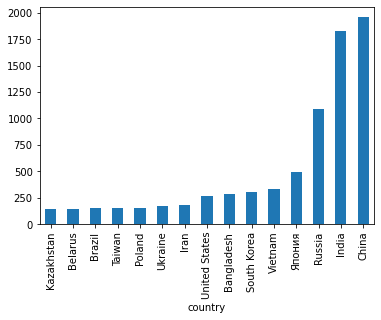

In [6]:
users_by_country.plot.bar()

Kot bi pričakovali, je iz držav z večjo populacijo več tekmovalcev.
Presenetljivo so ZDA šele na osmem mestu, čeprav so tretja največja država po populaciji in so dokaj razvita država. (Morda raje igrajo Fortnite kot pa programirajo)  
Kako pa zgledajo podatki, če se omejimo samo na najboljših 4000 tekmovalcev.

In [7]:
best_by_country = users.sort_values("best_place")[:4000].groupby("country").size().sort_values().tail(15)
best_by_country

country
Brazil            41
Egypt             41
Bangladesh        47
Kazakhstan        48
Taiwan            54
Poland            56
Ukraine           61
Iran              65
Vietnam           87
United States     92
South Korea       97
Япония           182
India            300
Russia           344
China            603
dtype: int64

<AxesSubplot:xlabel='country'>

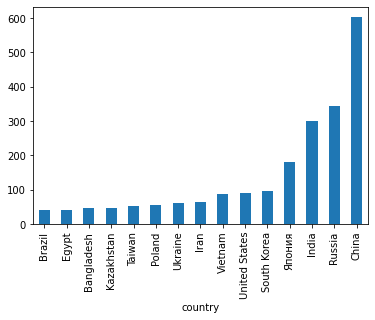

In [8]:
best_by_country.plot.bar()

Pomembna stvar, ki jo opazimo je, da je zelo majhen del tekmovalcev iz Indije med najboljšimi 10 % (oziroma med najboljšimi 4000 tekmovalci), če tekmovalce razvrstimo po njihovi najboljši uvrstitvi na zadnjih 200 tekmovanjih.  

Poskusimo definirati boljšo oceno za to, kako dobri so tekmovalci iz posamezne države. Vsak tekmovalec si bo prislužil `201 - najboljša_uvrstitev` točk. Število točk neke države bo potem kar vsota točk vseh tekmovalcev iz te države. Od tu do konca razdelka bomo upoštevli le države z vsaj 30 tekmovalci.

,country,score,users
3,Antarctica,5652,44
5,Armenia,5150,36
11,Bangladesh,28911,289
12,Belarus,17127,148
19,Brazil,17118,149
...,...,...,...
120,Turkey,6432,47
122,Ukraine,21590,169
124,United States,32774,265
127,Vietnam,39958,332


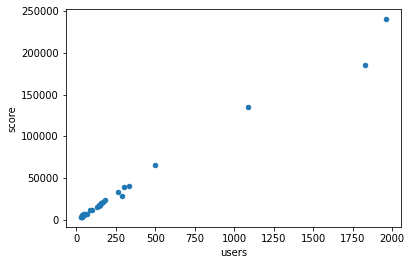

In [9]:
users["score"] = 201 - users.best_place
score_by_country = users.groupby("country", as_index=False)["score"].sum()
users_by_country = users.groupby("country", as_index=False).size().rename(columns={'size':'users'})
score_to_users = pd.merge(score_by_country, users_by_country, left_on='country', right_on='country')
score_to_users = score_to_users[score_to_users.users > 30]
score_to_users.plot.scatter("users", "score")
score_to_users

Opazimo, da število točk vsake države linearno narašča s številom tekmovalcev iz te države.
Kljub temu pa nekatere države odstopajo. Kot smo že prej ugotovili ima Indija v primerjavi z ostalimi državami majhen delež res dobrih programerjev. Na tem grafu Indijo predstavlja druga pika iz desne proti levi. Vidimo, da ima res majhno število točk glede na število tekmovalcev.  

Oglejmo si še države z največjim številom točk na tekmovalca.

<AxesSubplot:xlabel='country'>

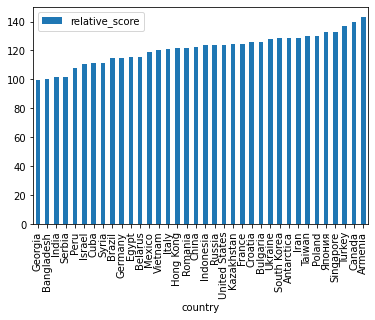

In [19]:
score_to_users["relative_score"] = score_to_users["score"] / score_to_users["users"]
score_to_users = score_to_users.sort_values("relative_score", ascending=True)
score_to_users.plot.bar(x='country', y='relative_score')

Iz grafa se vidi katere države so bolj uspešne in katere manj. Indija je med manj uspešnimi, kot so nam to kazali podatki že prej. Nekatere azijske države so pri vrhu, vendar ne moremo ravno reči, da so programerji iz azije precej bolj uspešni. Razlog za to, da so vedno pri vrhu je morda predvsem to, da jih je veliko.

Zavedati se moramo, da ti podatki niso bili najbolj primerni za analizo tega, kako dobri v programerskih nalogah so ljudje iz različnih držav, saj vsebujejo le prvih 200 tekmovalcev na vsakem tekmovanju.

## Najbolj popularni programski jeziki
Smiselno se je vprašati, katerih jezikih najraje programerajo tekmovalci.

In [13]:
po_jezikih = submissions.groupby("proglang").size()
popularni_jeziki = po_jezikih.sort_values()[-5:]
popularni_jeziki

proglang
java        3421
python      3595
Q#          4516
Kotlin      4606
c++       150496
dtype: int64

<AxesSubplot:xlabel='proglang'>

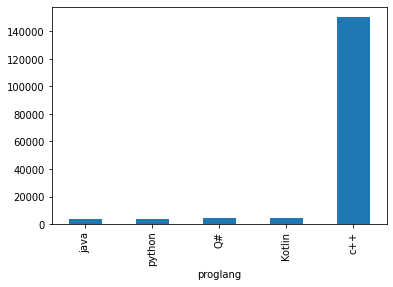

In [14]:
popularni_jeziki.plot.bar()

Vidimo, da je daleč najbolj popularen jezik med tekmovalnimi programerji c++, python pa je šele na petem mestu. To ni presenetljivo, saj je c++ precej hitrejši od pythona. Vseeno smo pričakovali, da bo v pythonu več oddaj kot se je izkazalo da jih je, saj je ponavadi prvih nekaj nalog zelo enostavnih in se jih hitreje reši v pythonu, kjer je koda ponavadi krajša.

In [15]:
size = len(submissions[submissions.proglang.notnull()])
cpp_part = popularni_jeziki.loc["c++"] / size
python_part = popularni_jeziki.loc["python"] / size
print("Delež oddaj v c++:", round(cpp_part*100, 2), "%")
print("Delež oddaj v pythonu: ", round(python_part*100, 2), "%")

Delež oddaj v c++: 86.63 %
Delež oddaj v pythonu:  2.07 %


Torej je v pythonu res manj kot 5 % vseh oddaj, presenetljivo pa je delež vseh oddaj v c++ samo 64 %, kar je precej manj kot 80 %.

In [16]:
pd.merge(users, submissions, left_on='id', right_on='user')

,name,rank,best_place,country,score,user,task,proglang,time
0,HIR180,Legendary Grandmaster,1,Япония,200,1,1,c++,1.0
1,HIR180,Legendary Grandmaster,1,Япония,200,1,2,c++,6.0
2,HIR180,Legendary Grandmaster,1,Япония,200,1,3,c++,65.0
3,HIR180,Legendary Grandmaster,1,Япония,200,1,4,c++,26.0
4,HIR180,Legendary Grandmaster,1,Япония,200,1,5,c++,26.0
...,...,...,...,...,...,...,...,...,...
234995,el.duivel,Expert,192,Bangladesh,9,14559,451,c++,33.0
234996,el.duivel,Expert,192,Bangladesh,9,14559,452,c++,52.0
234997,el.duivel,Expert,192,Bangladesh,9,14559,453,c++,106.0
234998,el.duivel,Expert,192,Bangladesh,9,14559,454,NaN,NaN


## Hitrost reševanja

V tem razdelku si bomo ogledali, če obstaja kakšna korelacija med hitrostjo nekdo reševanja nalog in tem, kako težke naloge je nekdo sposoben rešiti.